In [1]:
import numpy as np

In [2]:
%run ../load_data.py
%run ../dir_utils.py

Using TensorFlow backend.


# Declare generator function

In [3]:
batch_size=128
#filepath='/home/zhampel/insight/data/mnist/pngs'
trainpath='/home/zhampel/insight/data/cifar-10-images'
data_dir_struct = DataDirStruct(trainpath)
train_gen, valid_gen = train_img_generator(dir_struct=data_dir_struct, \
                                           batch_size=batch_size, \
                                           val_split=0.2)

Classes: 10, Image Dims: (32, 32)
Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [4]:
test_gen = test_img_generator(dir_struct=data_dir_struct, \
                              batch_size=batch_size)
print(test_gen.image_shape)
print(test_gen.num_classes)
print(test_gen.batch_size)

Classes: 10, Image Dims: (32, 32)
Found 10000 images belonging to 10 classes.
(32, 32, 3)
10
128


In [5]:
import keras
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils


np.random.seed(1671)
np.set_printoptions(threshold='nan')

In [6]:
class History(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [7]:
from keras.layers.convolutional import Convolution2D
from keras import backend as K
import tensorflow as tf

In [8]:
permutation = [[1, 0], [0, 0], [0, 1], [2, 0], [1, 1], [0, 2], [2, 1], [2, 2], [1, 2]]


def shift_rotate(w, shift=1):
    shape = w.get_shape()
    for i in range(shift):
        w = tf.reshape(tf.gather_nd(w, permutation), shape)
    return w

In [9]:
# Initialize session
import tensorflow as tf

sess = tf.InteractiveSession()

# Some tensor we want to print the value of
a = tf.constant([1.0, 3.0])

# Add print operation
a = tf.Print(a, [a], message="This is a: ")

# Add more elements of the graph using a
b = tf.add(a, a)

b_eval = b.eval()
sess.close()

In [14]:
class Convolution2D_4(Convolution2D):
    def call(self, x, mask=None):
        w = self.kernel
        w_rot = [w]
        for i in range(3):
            w = shift_rotate(w, shift=2)
            w_rot.append(w)

        outputs = tf.stack([K.conv2d(x, w_i, strides=self.strides,
                                     padding=self.padding,
                                     data_format=self.data_format) for w_i in w_rot])

        output = K.max(outputs, 0)

        if self.bias:
            if self.data_format == 'channels_first':
                output += K.reshape(self.bias, (1, self.filters, 1, 1))
            elif self.data_format == 'channels_last':
                output += K.reshape(self.bias, (1, 1, 1, self.filters))
            else:
                raise ValueError('Invalid data_format:', self.data_format)
        output = self.activation(output)
        return output

In [16]:
# Grab input shape and class numbers from generator
# Specifics
batch_size = test_gen.batch_size
epochs = 100
input_shape = train_gen.image_shape
num_classes = train_gen.num_classes
# History
history = History()
# Model
model = Sequential()
#model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
#                 activation='relu',
#                 input_shape=input_shape))
model.add(Convolution2D_4(32, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu',
                          use_bias=False,
                          input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Convolution2D_4(64, kernel_size=(3, 3),
                          use_bias=False, 
                          padding='same', 
                          activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [17]:
# Run the training
model.fit_generator(train_gen,
                    steps_per_epoch=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=valid_gen,
                    validation_steps=10,
                    class_weight=None,
                    callbacks=[history])

Epoch 1/100
128/128 [==============================] - 7s 55ms/step - loss: 1.8026 - acc: 0.3466 - val_loss: 1.6028 - val_acc: 0.4430
Epoch 2/100
128/128 [==============================] - 6s 47ms/step - loss: 1.4691 - acc: 0.4781 - val_loss: 1.4663 - val_acc: 0.4867
Epoch 3/100
128/128 [==============================] - 6s 47ms/step - loss: 1.3316 - acc: 0.5293 - val_loss: 1.3266 - val_acc: 0.5250
Epoch 4/100
128/128 [==============================] - 6s 47ms/step - loss: 1.2267 - acc: 0.5655 - val_loss: 1.2404 - val_acc: 0.5773
Epoch 5/100
128/128 [==============================] - 6s 47ms/step - loss: 1.1688 - acc: 0.5906 - val_loss: 1.3359 - val_acc: 0.5352
Epoch 6/100
128/128 [==============================] - 6s 47ms/step - loss: 1.0979 - acc: 0.6111 - val_loss: 1.1211 - val_acc: 0.6180
Epoch 7/100
128/128 [==============================] - 6s 47ms/step - loss: 1.0719 - acc: 0.6268 - val_loss: 1.1570 - val_acc: 0.5992
Epoch 8/100
128/128 [==============================] - 6s 47ms

Epoch 62/100
128/128 [==============================] - 6s 47ms/step - loss: 0.0178 - acc: 0.9955 - val_loss: 2.1375 - val_acc: 0.6695
Epoch 63/100
128/128 [==============================] - 6s 47ms/step - loss: 0.0219 - acc: 0.9935 - val_loss: 2.1490 - val_acc: 0.6828
Epoch 64/100
128/128 [==============================] - 6s 48ms/step - loss: 0.0494 - acc: 0.9842 - val_loss: 2.2038 - val_acc: 0.6680
Epoch 65/100
128/128 [==============================] - 6s 47ms/step - loss: 0.0771 - acc: 0.9740 - val_loss: 2.0853 - val_acc: 0.6695
Epoch 66/100
128/128 [==============================] - 6s 47ms/step - loss: 0.0633 - acc: 0.9782 - val_loss: 2.2627 - val_acc: 0.6484
Epoch 67/100
128/128 [==============================] - 6s 47ms/step - loss: 0.0462 - acc: 0.9847 - val_loss: 2.1000 - val_acc: 0.6602
Epoch 68/100
128/128 [==============================] - 6s 47ms/step - loss: 0.0390 - acc: 0.9876 - val_loss: 2.1254 - val_acc: 0.6805
Epoch 69/100
128/128 [==============================] -

In [18]:
# Evaluate score
score = model.evaluate_generator(test_gen, steps=20, max_queue_size=256)
print("Test score: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

Test score: 2.478132927417755
Test accuracy: 0.677734375


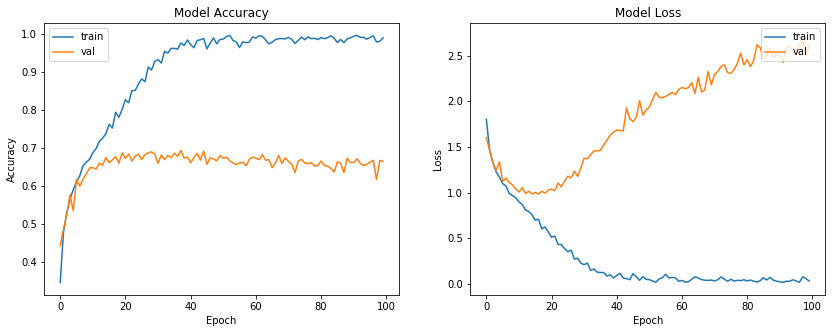

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Summarize history
f = plt.figure(figsize=(14,5))

# Summarize accuracy history
plt.subplot(1,2,1)
plt.plot(history.acc)
plt.plot(history.val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# Summarize loss history
plt.plot(history.loss)
plt.plot(history.val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()